In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import os
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dense, Dropout , BatchNormalization, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import random
SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [4]:
# the data_path is obtained after operations in the data_exploration.ipynb
data_path = 'data/redistributed'
train_path = Path(data_path) / 'train'
test_path = Path(data_path) / 'test'
val_path = Path(data_path) / 'val'

LABELS = ['NORMAL', 'PNEUMONIA']
IMG_SIZE = 224
GRAYSCALE = False
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 0.001
color_mode = 'grayscale' if GRAYSCALE else 'rgb'

# Loading Dataset

In [5]:
train = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED
)

val = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

test = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='int',
    class_names=LABELS,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
)

Found 6293 files belonging to 2 classes.
Found 586 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


# Data Preprocessing

## Data Normalization

In [6]:
normalization_layer = Rescaling(1./255)

train = train.map(lambda x, y: (normalization_layer(x), y))
val = val.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))

In [7]:
train.as_numpy_iterator().next()[0].max()

1.0

In [23]:
train.as_numpy_iterator().next()[0].min()

0.0

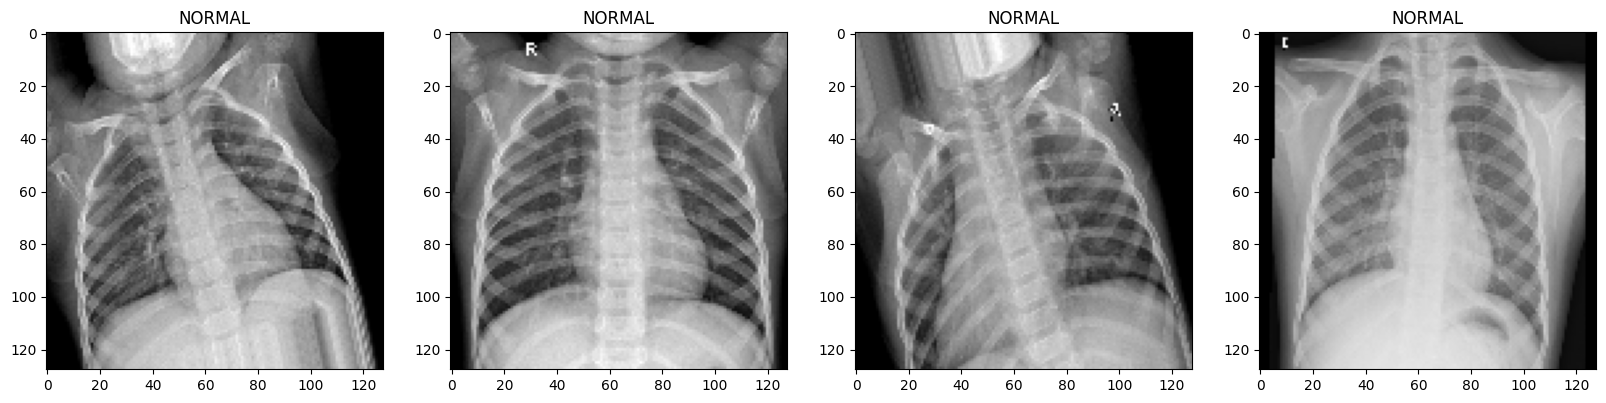

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
batch = train.as_numpy_iterator().next()
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img, cmap='gray' if GRAYSCALE else None)
    ax[idx].title.set_text(LABELS[batch[1][idx]])

## Data optimization

In [7]:
# use tensorflow to prefetch data for better performance
train_ds = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
for images, labels in train_ds.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

for images, labels in val_ds.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

for images, labels in test_ds.take(1):
    print(f"Image shape: {images.shape}, dtype: {images.dtype}")
    print(f"Label shape: {labels.shape}, dtype: {labels.dtype}")

Image shape: (16, 224, 224, 3), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>
Image shape: (16, 224, 224, 3), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>
Image shape: (16, 224, 224, 3), dtype: <dtype: 'float32'>
Label shape: (16,), dtype: <dtype: 'int32'>


# Model Building

In [9]:
def build_vgg16_model(optimizer, metrics, loss_function, input_shape):
    vgg16_base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    vgg16_base_model.trainable = False
    vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])
    vgg16_model.compile(optimizer=optimizer, 
                        loss=loss_function,
                        metrics=metrics)

    return vgg16_model

loss_function, optimizer = BinaryFocalCrossentropy(), Adam(learning_rate=LEARNING_RATE)
METRICS = ['accuracy']
vgg16_model = build_vgg16_model(optimizer=optimizer,
                                metrics=METRICS, 
                                loss_function=loss_function,
                                input_shape=(IMG_SIZE,IMG_SIZE,3))
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,054,145 (57.43 MB)

 Trainable params: 338,049 (1.29 MB)

 Non-trainable params: 14,716,096 (56.14 MB)

# Model training

In [2]:
train_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_type = 'vgg16'

# callback to reduce learning rate when the model stops improving
lr_reduction_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)

# save best model
checkpoint_filepath = os.path.join('models', model_type, train_time, "checkpoint.model.keras")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

# tensorboard callback
log_dir = os.path.join("logs", model_type, train_time)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [11]:
history = vgg16_model.fit(train_ds, 
                    epochs=EPOCHS, 
                    validation_data=val_ds, 
                    callbacks=[lr_reduction_callback, model_checkpoint_callback, tensorboard_callback])

Epoch 1/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7988 - loss: 0.2263
Epoch 1: val_accuracy improved from -inf to 0.92321, saving model to models/vgg16/20250108-220943/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 67s 159ms/step - accuracy: 0.7990 - loss: 0.2261 - val_accuracy: 0.9232 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 2/15
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8804 - loss: 0.0942
Epoch 2: val_accuracy improved from 0.92321 to 0.94198, saving model to models/vgg16/20250108-220943/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 56s 141ms/step - accuracy: 0.8805 - loss: 0.0941 - val_accuracy: 0.9420 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 3/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9048 - loss: 0.0709
Epoch 3: val_accuracy improved from 0.94198 to 0.95392, saving model to models/vgg16/20250108-220943/checkpoint.model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - accuracy: 0.9049 - loss: 0.0709 -

In [4]:
# load best model
checkpoint_filepath = "models/vgg16/20250108-220943/checkpoint.model.keras"
model = load_model(checkpoint_filepath)

# Model evaluation

In [5]:
res_dir = os.path.join("res", model_type, train_time)
os.makedirs(res_dir, exist_ok=True)

In [6]:
print("Test Set Evaluation")
loss, accuracy = model.evaluate(test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy * 100}%")

Test Set Evaluation


NameError: name 'test' is not defined

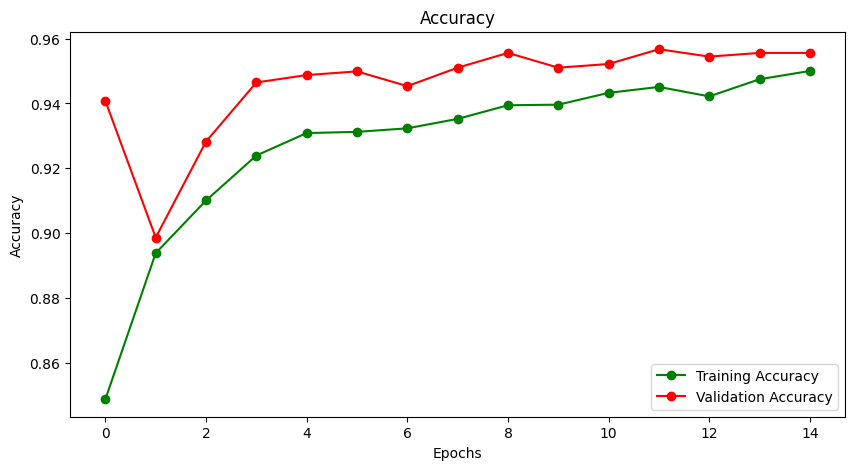

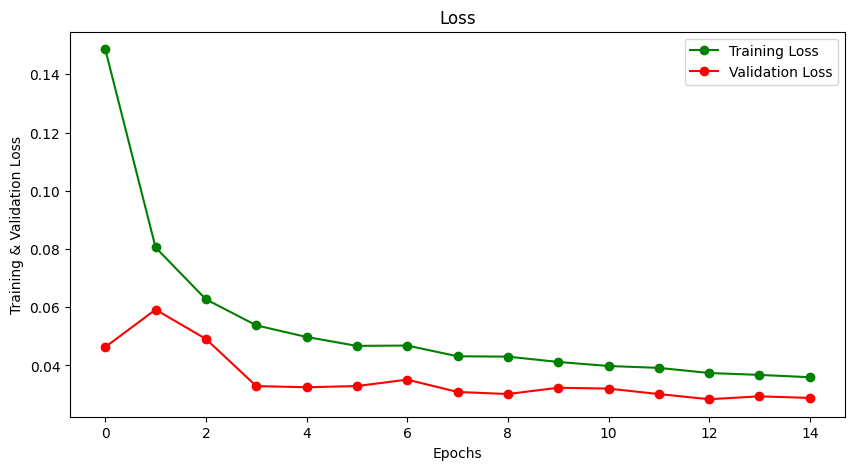

In [16]:
x_epochs = [i for i in range(EPOCHS)]

# train metrics
train_acc = history.history['accuracy']
train_loss = history.history['loss']

# validation metrics
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Plot and save Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(x_epochs, train_acc, 'go-', label='Training Accuracy')
plt.plot(x_epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(os.path.join(res_dir, "training_accuracy.png"))
plt.show()

# Plot and save Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(x_epochs, train_loss, 'g-o', label='Training Loss')
plt.plot(x_epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Loss")
plt.savefig(os.path.join(res_dir, "training_loss.png"))
plt.show()

In [17]:
predictions = (model.predict(test) > 0.5).astype(int) # for binary classification
y_pred = predictions.reshape(predictions.shape[0])
y_pred

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [18]:
y_true = []
for _, labels in test.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

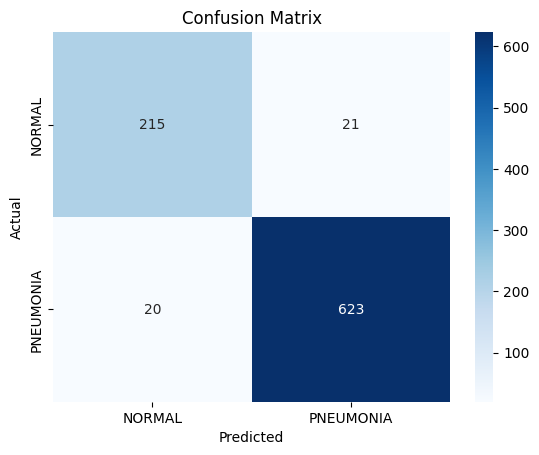

In [19]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABELS,
            yticklabels=LABELS,)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, columns=LABELS, index=LABELS)
conf_matrix_df.to_csv(os.path.join(res_dir, "confusion_matrix.csv"))

In [20]:
report = classification_report(y_true, y_pred, target_names=LABELS)
print(report)

# save classification report
with open(os.path.join(res_dir, "classification_report.txt"), "w") as f:
    f.write(report)

              precision    recall  f1-score   support

      NORMAL       0.91      0.91      0.91       236
   PNEUMONIA       0.97      0.97      0.97       643

    accuracy                           0.95       879
   macro avg       0.94      0.94      0.94       879
weighted avg       0.95      0.95      0.95       879

